In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from tqdm import tqdm 

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
class PalmDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir,transform=transform)
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    
    @property
    def classes(self):
        return self.data.classes
    

In [49]:
transfromer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [50]:
test_dir = 'test'
test_dataset = PalmDataset(test_dir,transform=transfromer)

In [51]:
for x,y in test_dataset:
    break


In [52]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
# Model
class PalmClassifier(nn.Module):
    def __init__(self, number_of_classes=9):
        super(PalmClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(128*28*28, number_of_classes)
        
        self.drop1 = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = self.drop1(x)
        x = self.fc1(x)
        
        return x

In [54]:
model = PalmClassifier()
device = torch.device('cuda:0')
model.load_state_dict(torch.load('best_palmdisease_cnn.pth'))

C:\Users\ahmad\AppData\Local\Temp\ipykernel_11924\1013437251.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_palmdisease_cnn.pth')

<All keys matched successfully>

In [55]:
# testing loop
model.to(device)
model.eval()
total = 0
predictions = []
labels = []
correct = 0
with torch.no_grad():
    for x, y in tqdm(test_loader,"test batch"):
        x, y = x.to(device), y.to(device)
        output = model(x)
        
        total += y.size(0)
        pr1,predicted = torch.max(output,1)
        preds = torch.argmax (output, 1)
        predictions.append(predicted.cpu())
        correct += (predicted == y).sum().item()
        labels.append(y.cpu())
        

test_accuracy = 100 * correct / total

test batch: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


In [56]:
test_accuracy

77.05479452054794

{'Black Scorch': 0, 'Fusarium Wilt': 1, 'Healthy sample': 2, 'Leaf Spots': 3, 'Magnesium Deficiency': 4, 'Manganese Deficiency': 5, 'Parlatoria Blanchardi': 6, 'Potassium Deficiency': 7, 'Rachis Blight': 8}


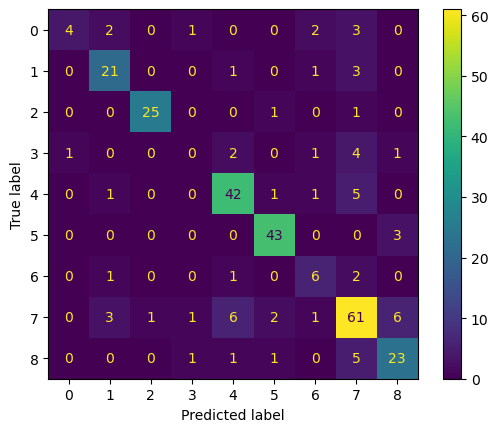

In [57]:

cm_predictions = [item for row in predictions for item in row]
cm_labels = [item for row in labels for item in row]

print(test_dataset.data.class_to_idx)
cm = confusion_matrix(cm_labels,cm_predictions)
ConfusionMatrixDisplay(cm).plot()